In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, f1_score, roc_auc_score
import sklearn

In [3]:
# Import datasets
Mov=pd.read_csv('../data/movie_lense/movies.csv',sep=',')
Rat=pd.read_csv('../data/movie_lense/ratings.csv')
Osc=pd.read_csv('../data/the_oscar_award.csv')
## Now start cleaning
# Transforming movies dataset: extract the years
def ext_movname(tlist):
    lst=tlist.copy()
    year=tlist.copy()
    for i in range(len(tlist)):
        raw=tlist[i].rstrip()
        try:
            year[i]=int(raw[-5:-1])
            lst[i]=raw[:-7]
        except:
            year[i]=np.nan
            lst[i]=raw
    return [lst,year]
u=ext_movname(Mov['title'])
Mov['title']=u[0]
Mov['year']=u[1]
CMov=Mov[Mov.year>=2008]
CMov=CMov.reset_index(drop=True)
# Function for recorrect the film name
def recorr(string):
    if '(' in string:
        nstr=string.split(' (')[0]
    else:
        nstr=string
    if ',' not in nstr:
        return nstr
    else:
        lst=nstr.split(sep=', ')
        if lst[-1] not in {'The', 'A'}:
            return nstr
        else:
            nlst=lst[:-1]
            new=lst[-1]+' '
            for j in nlst:
                new=new+j
            return new
CMov['title']=CMov['title'].apply(recorr)
# Choose the ceremony year and file name columns
C_osc=Osc[['year_ceremony','film']].dropna().copy()
C_osc=C_osc.reset_index(drop=True)
C_osc['film']=C_osc['film'].apply(recorr)
for i in range(len(C_osc)):
    if C_osc['film'][i][-1]==';':
        u=C_osc['film'][i][-1]
        C_osc['film'][i]=u[:-1]
C_osc=C_osc[C_osc.year_ceremony>=2009]
C_osc=C_osc.drop_duplicates(subset=['film'], keep='first').reset_index(drop=True)
# Combine into CMov
D_osc={C_osc['film'][i]:C_osc['year_ceremony'][i] for i in range(len(C_osc))}
lst=[]
for i in range(len(CMov['title'])):
    if CMov['title'][i] in D_osc:
        lst.append(D_osc[CMov['title'][i]])
    else:
        lst.append(0)
CMov['Oscar']=lst
cls=[int(i>0) for i in lst]
CMov['Class']=cls
ava_y=CMov['Oscar']
cmp_y=CMov['year']
for i in range(len(ava_y)):
    if ava_y[i]==0:
        ava_y[i]=cmp_y[i]+1
CMov['Oscar']=ava_y
# Transfering timestamp: extract the year data
def extract_year(time_se):
    return time.localtime(time_se).tm_year
Ye=Rat['timestamp'].apply(extract_year)
Rat['timestamp']=Ye
# Merge CMov and Rat, and filter the available rating times
R_Mov=pd.merge(CMov,Rat,on=['movieId'])
Ava_rating=R_Mov[((R_Mov.timestamp<=R_Mov.Oscar) & (R_Mov.timestamp>=R_Mov.Oscar-1))].reset_index(drop=True)[['movieId','Class','rating']]
# Using groupby to get count, mean and var
g_rat=Ava_rating.groupby(by=['movieId','Class'],as_index=False)
Sta_rate=g_rat.count()
Sta_rate['mean']=g_rat.mean()['rating']
Sta_rate['std']=g_rat.std()['rating'].fillna(0)
# Change column name
colname=list(Sta_rate.columns)
colname[2]='lg_ratetimes'
colname[3]='rate_mean'
colname[4]='rate_std'
Sta_rate.columns=colname

/home/sbg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sbg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(array([1.0918e+04, 1.3800e+02, 3.3000e+01, 1.9000e+01, 9.0000e+00,
        5.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([1.0000e+00, 1.0935e+03, 2.1860e+03, 3.2785e+03, 4.3710e+03,
        5.4635e+03, 6.5560e+03, 7.6485e+03, 8.7410e+03, 9.8335e+03,
        1.0926e+04]),
 <a list of 10 Patch objects>)

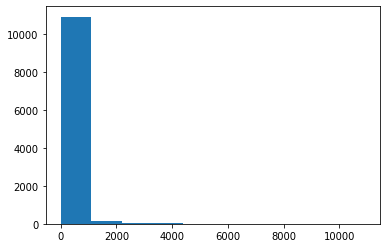

In [4]:
plt.hist(Sta_rate['lg_ratetimes'])

In [5]:
Sta_rate['lg_ratetimes']=Sta_rate['lg_ratetimes'].apply(np.log10)  # log transform the counts

In [6]:
plt.hist(df.lg_ratetimes)

NameError: name 'df' is not defined

In [7]:
Sta_rate.to_csv("Sta_rate.csv")

In [8]:
# Finally, apply logistic regression
Y=Sta_rate['Class']
X=Sta_rate[['lg_ratetimes','rate_mean','rate_std']]
# Random shuffle, and split dataset
np.random.seed(625)
rp=np.random.permutation(len(Y))
X_train=X.iloc[rp[2000:]]
X_test=X.iloc[rp[:2000]]
Y_train=Y.iloc[rp[2000:]]
Y_test=Y.iloc[rp[:2000]]
# Model fitting
clf=LogisticRegression(class_weight='balanced').fit(X_train,Y_train)

/home/sbg/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
# Model coefficients
expr='logit(p)='+str(round(clf.intercept_[0],4))+'+'+str(round(clf.coef_[0][0],4))+'log(rate_times)'+'+'+str(round(clf.coef_[0][1],4))+'rate_mean'+'+'+str(round(clf.coef_[0][2],4))+'rate_std'
print(expr)
# This means the model is logit(p)=-4.2509+0.6389log(rate_times)+0.7838rate_mean+-0.8406rate_std

logit(p)=-4.0809+1.4732log(rate_times)+0.7424rate_mean+-0.8771rate_std


In [10]:
# Now using upon testing dataset
# Fitting score
clf.score(X_test,Y_test)

0.8345

In [11]:
# Or:
err=np.mean(clf.predict(X_test)!=Y_test)
print('The test error is:  %.2f%%' % (err*100))

The test error is:  16.55%


In [12]:
# Try statsmodels.api for Statistical Inference
import statsmodels.api as sm
import statsmodels.formula.api as smf
# First of all, get the frequency weight, which is the same as that in 
# LogisticRegression(class_weight='balanced')
np.random.seed(625)
rp=np.random.permutation(len(Y))
Train=Sta_rate.iloc[rp[2000:]]
Test=Sta_rate.iloc[rp[:2000]]
W=Train.groupby('Class').count()['movieId']
Train['weight']=(W[1]+(W[0]-W[1])*Train['Class'])/W[1]

/home/sbg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# Using logistic regression.
glm=smf.glm('Class~lg_ratetimes+rate_mean+rate_std',data=Train,
            family=sm.families.Binomial(),
           freq_weights=Train['weight'])
clf2=glm.fit()

In [14]:
# First of all, the summary
clf2.summary()
# According to the result, all of the parameter tests are remarkable.
# And the results in the two models are really close.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:                 9131
Model:                            GLM   Df Residuals:                 17440.00
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8075.5
Date:                Fri, 18 Sep 2020   Deviance:                       16151.
Time:                        17:06:08   Pearson chi2:                 2.06e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.2507      0.150    -28.369      0.000      -4.544      -3.957
lg_ratetimes     1.4726      0.025     58.090      0.000       1.423       1.522
rate_mean        0.7845      0.039     20.323      0.000       0.709       0.860
rate_std        -0.8467      0.066    -12.910      0.000      -0.975      -0.718
================================================================================
"""

In [15]:
# This predicting error
pred=clf2.predict(X_test)
err2=np.mean((pred>0.5)!=Y_test)
print('The test error is:  %.2f%%' % (err2*100))

The test error is:  16.70%


In [16]:
# Finally we focus on the error upon different classes
# Using LogisticRegression in scikit:
# The Oscar class(label 1)
C1=clf.predict(X_test[Y_test==1])
err_c1=np.mean(C1!=1)
print('The test error in class 1 is:  %.2f%%' % (err_c1*100))
# The Non-Oscar class(label 0)
C2=clf.predict(X_test[Y_test==0])
err_c2=np.mean(C2!=0)
print('The test error in class 0 is:  %.2f%%' % (err_c2*100))

The test error in class 1 is:  27.27%
The test error in class 0 is:  16.12%


In [17]:
# Using glm in statsmodels:
# The Oscar class(label 1)
C1_s=clf2.predict(X_test[Y_test==1])
err_c1s=np.mean((C1_s>=0.5)!=1)
print('The test error in class 1 is:  %.2f%%' % (err_c1s*100))
# The Non-Oscar class(label 0)
C2_s=clf2.predict(X_test[Y_test==0])
err_c2s=np.mean((C2_s<0.5)!=1)
print('The test error in class 0 is:  %.2f%%' % (err_c2s*100))

The test error in class 1 is:  27.27%
The test error in class 0 is:  16.28%


In [18]:
## Or: consider confusion matrix
from sklearn.metrics import confusion_matrix
M1=confusion_matrix(Y_test,clf.predict(X_test))

In [19]:
M1

array([[1613,  310],
       [  21,   56]])

In [20]:
M2=confusion_matrix(Y_test,clf2.predict(X_test)>0.5)

In [21]:
# Add: Correlation matrix of the three parameters

Text(0.5, 1, 'Heatmap of the correlation matrix upon total data')

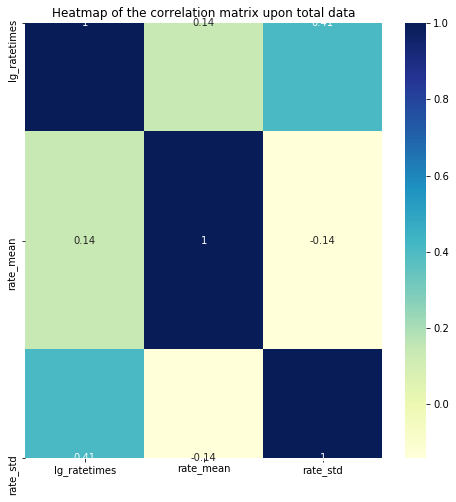

In [22]:
import seaborn as sn
Cor_total=np.corrcoef(X,rowvar=0)
fig,ax=plt.subplots(figsize=(8,8))
sn.heatmap(Cor_total,annot=True,cmap="YlGnBu")
ax.set_xticklabels(list(X.columns))
ax.set_yticklabels(list(X.columns))
ax.set_title('Heatmap of the correlation matrix upon total data')

Text(0.5, 1, 'Heatmap of the correlation matrix upon training data')

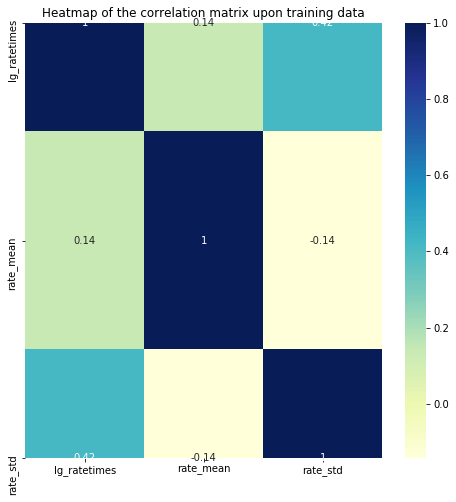

In [23]:
Cor_train=np.corrcoef(X_train,rowvar=0)
fig,ax=plt.subplots(figsize=(8,8))
sn.heatmap(Cor_train,annot=True,cmap="YlGnBu")
ax.set_xticklabels(list(X_train.columns))
ax.set_yticklabels(list(X_train.columns))
ax.set_title('Heatmap of the correlation matrix upon training data')

Text(0.5, 1, 'Heatmap of the correlation matrix upon testing data')

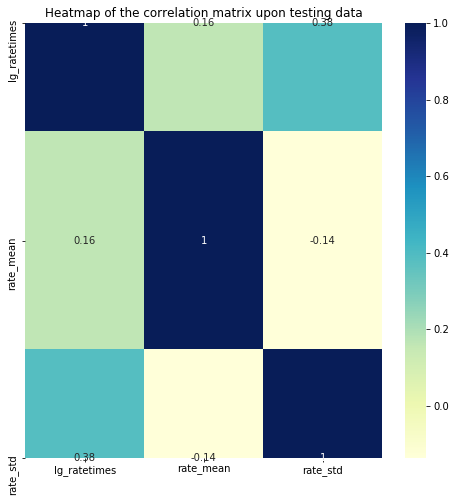

In [24]:
Cor_test=np.corrcoef(X_test,rowvar=0)
fig,ax=plt.subplots(figsize=(8,8))
sn.heatmap(Cor_test,annot=True,cmap="YlGnBu")
ax.set_xticklabels(list(X_test.columns))
ax.set_yticklabels(list(X_test.columns))
ax.set_title('Heatmap of the correlation matrix upon testing data')

## Logistic regression diagnostics

In [25]:
df = Sta_rate

In [26]:
df.columns

Index(['movieId', 'Class', 'lg_ratetimes', 'rate_mean', 'rate_std'], dtype='object')

In [27]:
#plt.hist(np.log((df.lg_ratetimes+10^))

SyntaxError: invalid syntax (<ipython-input-27-24c5549f6cda>, line 1)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
y = df.Class
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [30]:
from sklearn.utils import resample

In [31]:
X = pd.concat([X_train, y_train], axis=1)
not_oscar = X[X.Class==0]
oscar = X[X.Class==1]

In [32]:
# upsample minority
oscar_upsampled = resample(oscar,
                          replace=True, # sample with replacement
                          n_samples=len(not_oscar), # match number in majority class
                          random_state=27) # reproducible results

In [33]:
upsampled = pd.concat([not_oscar, oscar_upsampled])

In [34]:
upsampled.Class.value_counts()

1    7981
0    7981
Name: Class, dtype: int64

In [35]:
upsampled.to_csv("upsampled.csv")

In [36]:
# Try statsmodels.api for Statistical Inference
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [37]:
# Using logistic regression.
glm=smf.glm('Class~lg_ratetimes+rate_mean+rate_std',data=upsampled,
            family=sm.families.Binomial())
clf2=glm.fit()

In [38]:
clf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:                15962
Model:                            GLM   Df Residuals:                    15958
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6909.6
Date:                Fri, 18 Sep 2020   Deviance:                       13819.
Time:                        17:06:46   Pearson chi2:                 2.55e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.7185      0.185    -30.932      0.000      -6.081      -5.356
lg_ratetimes     1.5485      0.028     56.155      0.000       1.494       1.603
rate_mean        1.1149      0.046     24.417      0.000       1.025       1.204
rate_std        -0.6212      0.075     -8.304      0.000      -0.768      -0.475
================================================================================
"""

In [39]:
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [40]:
f1_score(y_test, y_pred)

0.1758241758241758

In [41]:
recall_score(y_test, y_pred)

0.6722689075630253

In [42]:
roc_auc_score(y_test, y_pred)

0.7026885078355667